In [346]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import re
import folium
import json
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

**Dataframe Preparation**

In [347]:
food = pd.read_pickle("food.pkl")
restaurants = pd.read_pickle("restaurants.pkl")

In [348]:
food.head()

Inspection ID             DBA Name             AKA Name  License #  \
0        2320830  THE HOXTON, CHICAGO  THE HOXTON, CHICAGO  2694640.0   
1        2320795                  TBD         THE EXCHANGE  2698572.0   
2        2320719  4884 S ARCHER INC,.  4884 S ARCHER INC,.  2678088.0   
3        2320659   MCDONALDï¿½S 25088         MCDONALDï¿½S  2671720.0   
4        2320662     DOLLOP COFFEE CO     DOLLOP COFFEE CO  2698381.0   

   Facility Type             Risk Zip Inspection Date        Inspection Type  \
0     Restaurant  Risk 2 (Medium)  07            2019                License   
1     Restaurant    Risk 1 (High)  54            2019                License   
2  Grocery Store     Risk 3 (Low)  32            2019                License   
3     Restaurant  Risk 2 (Medium)  01            2019  License Re-Inspection   
4     Restaurant    Risk 1 (High)  13            2019                License   

              Results                                         Violations  \
0                Pass  36. THERMOMETERS PROVIDED & ACCURATE - Comment...   
1                Pass                                                NaN   
2                Fail                                                NaN   
3                Pass                                                NaN   
4  Pass w/ Conditions  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...   

    Latitude  Longitude                    geometry        community area  \
0  41.885699 -87.648789  POINT (-87.64879 41.88570)   NEAR WEST SIDE    0   
1  41.887529 -87.632647  POINT (-87.63265 41.88753)  NEAR NORTH SIDE    0   
2  41.804621 -87.719907  POINT (-87.71991 41.80462)   ARCHER HEIGHTS    0   
3  41.886567 -87.624385  POINT (-87.62438 41.88657)             LOOP    0   
4  41.961681 -87.670762  POINT (-87.67076 41.96168)           UPTOWN    0   

      shape_area area_num_1 area_numbe      shape_len  
0  158492466.554         28         28  53003.5929406  
1  76675895.9728          8          8  57293.1649516  
2  55922505.7212         57         57  31880.0210295  
3  46335565.4586         32         32  39428.6729962  
4  65095642.7289          3          3  46972.7945549

In [349]:
restaurants["Facility Type"].unique().tolist()

['Restaurant']

**Risk analysis:**

1) Pourcentage de 1, 2 et 3 sur chaque année

2) Différences niveaux pour même chaîne (lié à la position?)

3) Notes des chaînes/écoles

4) Distributions des notes par année

**1. Percentage distribution of risk level throughout the years** 

In [350]:
#risk distribution for every year
year_list = food["Inspection Date"].unique().tolist()
year_list.sort()
all_risks =  [[0 for _ in range(3)] for _ in range(len(year_list))]
year = 0
for i in year_list:
    all_risks[year] = food[food["Inspection Date"]==i].Risk.value_counts().sort_index().tail(3).tolist()
    year += 1

In [351]:
all_risks[0]

[9723, 3317, 1295]

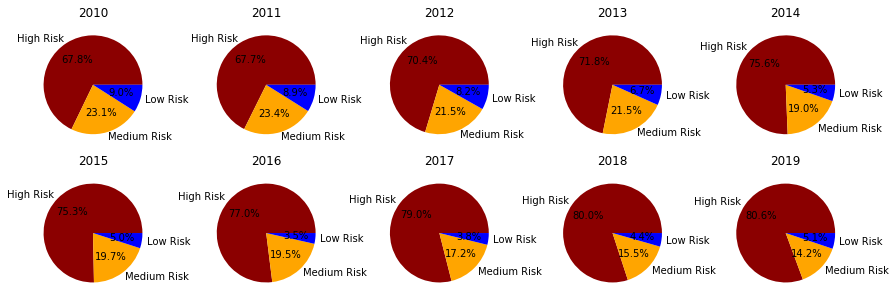

In [352]:
#plotting
labels = ['High Risk', 'Medium Risk', 'Low Risk']
fig, ax= plt.subplots(2,int(len(year_list)/2),figsize=(15,5))

year = 0
for i in range(2):
    for j in range(int(len(year_list)/2)):
        ax[i,j].pie(all_risks[year], labels = labels, autopct='%1.1f%%', colors=["darkred","orange","blue"])
        ax[i,j].set_title(year_list[year])
        year += 1

plt.show()

**Discussion**

We see that the distribution of different risk levels has slowly changed since 2010. There is a slow increase in high risk aka fast foods 

**Representation on a linear graph**

Before plotting, we need to normalize the data to be able to compare the evolution throughout the years

Text(0, 0.5, 'Percentage')

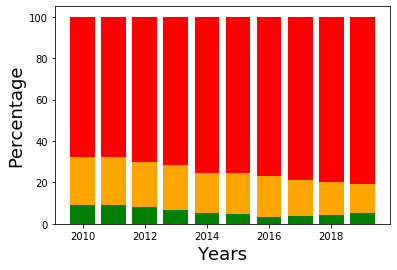

In [353]:
#x axis
years = [0]*len(year_list)
for i in range(0,len(year_list)):
    years[i]=2010+i

#y axis
scores1 = [100]*len(year_list)
scores2 = [0]*len(year_list)
scores3 = [0]*len(year_list)

#Plotting 
for j in range(0,len(year_list)):
    #scores1[j]= 100*(food[food["Inspection Date"]==year_list[j]].Risk.value_counts().sort_index().head().tolist()[0])/\
    #                (food[food["Inspection Date"]==year_list[j]].Risk.count())
    scores3[j]= 100*(food[food["Inspection Date"]==year_list[j]].Risk.value_counts().sort_index().head().tolist()[2])/\
                    (food[food["Inspection Date"]==year_list[j]].Risk.count())
    scores2[j]= 100*(food[food["Inspection Date"]==year_list[j]].Risk.value_counts().sort_index().head().tolist()[1])/\
                    (food[food["Inspection Date"]==year_list[j]].Risk.count())+scores3[j]

plt.bar(years, scores1, color='red')
plt.bar(years, scores2, color='orange')
plt.bar(years, scores3, color ='green')

plt.xlabel("Years", fontsize=18)
plt.ylabel("Percentage", fontsize=18)

**Risk analysis per restaurant for 2018**

In [354]:
new_restaurants = restaurants[restaurants["Inspection Date"]=='2018'].copy()
new_restaurants.reset_index(drop=True, inplace=True)

In [355]:
new_restaurants.head(10)

Inspection ID             DBA Name       AKA Name  License # Facility Type  \
0        2243942        DUNKIN DONUTS  DUNKIN DONUTS  2536449.0    Restaurant   
1        2243941        DUNKIN DONUTS  DUNKIN DONUTS    23610.0    Restaurant   
2        2243922               SUBWAY         SUBWAY  1947909.0    Restaurant   
3        2243903               SUBWAY         SUBWAY  1980425.0    Restaurant   
4        2243876               SUBWAY         SUBWAY  2221641.0    Restaurant   
5        2243885           MCDONALD'S      MCDONALDS  2637057.0    Restaurant   
6        2243872               SUBWAY         SUBWAY  1904894.0    Restaurant   
7        2243828      SUBWAY SANDWICH         SUBWAY  2374636.0    Restaurant   
8        2243844  TARGET STORE # 1889      STARBUCKS  1515016.0    Restaurant   
9        2243835        Dunkin Donuts  DUNKIN DONUTS  1986419.0    Restaurant   

              Risk Zip Inspection Date        Inspection Type  \
0  Risk 2 (Medium)  54            2018                Canvass   
1  Risk 2 (Medium)  60            2018                Canvass   
2    Risk 1 (High)  29            2018                Canvass   
3    Risk 1 (High)  34            2018                Canvass   
4    Risk 1 (High)  29            2018  Canvass Re-Inspection   
5  Risk 2 (Medium)  32            2018                License   
6    Risk 1 (High)  05            2018                Canvass   
7    Risk 1 (High)  05            2018                Canvass   
8  Risk 2 (Medium)  05            2018                Canvass   
9  Risk 2 (Medium)  05            2018                Canvass   

              Results                                         Violations  \
0  Pass w/ Conditions  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   
1                Pass  49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...   
2  Pass w/ Conditions  5. PROCEDURES FOR RESPONDING TO VOMITING AND D...   
3  Pass w/ Conditions  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   
4                Pass  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...   
5                Pass  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...   
6     Out of Business                                                NaN   
7  Pass w/ Conditions  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   
8                Pass  51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...   
9  Pass w/ Conditions  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   

    Latitude  Longitude                    geometry        community area  \
0  41.896458 -87.636098  POINT (-87.63610 41.89646)  NEAR NORTH SIDE    0   
1  41.995853 -87.670347  POINT (-87.67035 41.99585)        EDGEWATER    0   
2  41.775287 -87.722819  POINT (-87.72282 41.77529)        WEST LAWN    0   
3  41.945599 -87.766599  POINT (-87.76660 41.94560)     PORTAGE PARK    0   
4  41.778859 -87.703405  POINT (-87.70340 41.77886)     CHICAGO LAWN    0   
5  41.808359 -87.696001  POINT (-87.69600 41.80836)    BRIGHTON PARK    0   
6  41.865676 -87.625944  POINT (-87.62594 41.86568)  NEAR SOUTH SIDE    0   
7  41.873925 -87.630803  POINT (-87.63080 41.87393)             LOOP    0   
8  41.867571 -87.630586  POINT (-87.63059 41.86757)             LOOP    0   
9  41.873997 -87.630806  POINT (-87.63081 41.87400)             LOOP    0   

      shape_area area_num_1 area_numbe      shape_len  
0  76675895.9728          8          8  57293.1649516  
1  48449990.8397         77         77  31004.8309456  
2  82315301.6831         65         65  41934.4901309  
3  110196097.139         15         15  46520.6421377  
4  98279465.1151         66         66  40073.0998382  
5  75892790.3114         58         58  36537.1343061  
6  49769639.4541         33         33  45053.1651038  
7  46335565.4586         32         32  39428.6729962  
8  46335565.4586         32         32  39428.6729962  
9  46335565.4586         32         32  39428.6729962

**Plotting on the city map**

In [356]:
#Keeping Canvass inspections and dropping duplicates (keep the highest risk level given)
new_restaurants = new_restaurants[new_restaurants["Inspection Type"]=="Canvass"]
new_restaurants.sort_values(by = "Risk", inplace=True)
new_restaurants.drop_duplicates(subset="License #", inplace=True)
new_restaurants.reset_index(drop=True, inplace=True)
new_restaurants

Inspection ID                    DBA Name       AKA Name  License #  \
0          2177026                      SUBWAY         SUBWAY  1801470.0   
1          2166318             SUBWAY SANDWICH         SUBWAY  1884292.0   
2          2166345                      SUBWAY         SUBWAY  2158242.0   
3          2166387                      SUBWAY         SUBWAY  2391330.0   
4          2166405                      SUBWAY         SUBWAY  2411733.0   
..             ...                         ...            ...        ...   
415        2214118  DUNKIN DONUTS/BASKIN ROBIN  DUNKIN DONUTS  1675002.0   
416        2214116                  McDONALD'S      MCDONALDS  1969969.0   
417        2167096      STARBUCKS COFFEE #2255      STARBUCKS    23069.0   
418        2243942               DUNKIN DONUTS  DUNKIN DONUTS  2536449.0   
419        2222949               DUNKIN DONUTS  DUNKIN DONUTS  2563522.0   

    Facility Type             Risk Zip Inspection Date Inspection Type  \
0      Restaurant    Risk 1 (High)  01            2018         Canvass   
1      Restaurant    Risk 1 (High)  66            2018         Canvass   
2      Restaurant    Risk 1 (High)  49            2018         Canvass   
3      Restaurant    Risk 1 (High)  01            2018         Canvass   
4      Restaurant    Risk 1 (High)  32            2018         Canvass   
..            ...              ...  ..             ...             ...   
415    Restaurant  Risk 2 (Medium)  30            2018         Canvass   
416    Restaurant  Risk 2 (Medium)  06            2018         Canvass   
417    Restaurant  Risk 2 (Medium)  06            2018         Canvass   
418    Restaurant  Risk 2 (Medium)  54            2018         Canvass   
419    Restaurant     Risk 3 (Low)  12            2018         Canvass   

                Results                                         Violations  \
0                  Fail  11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...   
1                  Fail  16. FOOD PROTECTED DURING STORAGE, PREPARATION...   
2                  Fail  18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...   
3    Pass w/ Conditions  21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...   
4                  Pass  32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...   
..                  ...                                                ...   
415                Pass  47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...   
416     Out of Business                                                NaN   
417                Pass  33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...   
418  Pass w/ Conditions  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   
419     Out of Business                                                NaN   

      Latitude  Longitude                    geometry        community area  \
0    41.885030 -87.626408  POINT (-87.62641 41.88503)             LOOP    0   
1    42.008536 -87.914428  POINT (-87.91443 42.00854)              NaN  NaN   
2    41.760632 -87.586333  POINT (-87.58633 41.76063)      SOUTH SHORE    0   
3    41.884586 -87.631010  POINT (-87.63101 41.88459)             LOOP    0   
4    41.813101 -87.723928  POINT (-87.72393 41.81310)   ARCHER HEIGHTS    0   
..         ...        ...                         ...              ...  ...   
415  41.975911 -87.787723  POINT (-87.78772 41.97591)   JEFFERSON PARK    0   
416  41.882700 -87.636638  POINT (-87.63664 41.88270)             LOOP    0   
417  41.881822 -87.635437  POINT (-87.63544 41.88182)             LOOP    0   
418  41.896458 -87.636098  POINT (-87.63610 41.89646)  NEAR NORTH SIDE    0   
419  41.877432 -87.671768  POINT (-87.67177 41.87743)   NEAR WEST SIDE    0   

        shape_area area_num_1 area_numbe      shape_len  
0    46335565.4586         32         32  39428.6729962  
1              NaN        NaN        NaN            NaN  
2    81812716.3958         43         43  44249.6461173  
3    46335565.4586         32         32  39428.6729962  
4    55922505.7212         

In [357]:
#An idea of statistics
new_restaurants.Risk.value_counts()

Risk 1 (High)      224
Risk 2 (Medium)    195
Risk 3 (Low)         1
Name: Risk, dtype: int64

In [358]:
#Function for plotting Chicago map with markers according to risk level
#Takes a dataframe and returns the map
def map_plot (df):
    #Creating the Chicago map
    chicago_coord = [41.85, -87.7]
    riskmap = folium.Map(location=chicago_coord)

    #Low risk
    for i in range(df[df.Risk.str.contains("3")].Latitude.shape[0]):
        risk_location = [df[df.Risk.str.contains("3")].Latitude.tolist()[i], 
                          df[df.Risk.str.contains("3")].Longitude.tolist()[i]]
        folium.Marker(risk_location, popup=df[df.Risk.str.contains("3")]["AKA Name"].tolist()[i], 
                      icon=folium.Icon(color ='blue', icon = 'map-marker')).add_to(riskmap)

    #Medium risk
    for i in range(df[df.Risk.str.contains("2")].Latitude.shape[0]):
        risk_location = [df[df.Risk.str.contains("2")].Latitude.tolist()[i], 
                          df[df.Risk.str.contains("2")].Longitude.tolist()[i]]
        folium.Marker(risk_location, popup=df[df.Risk.str.contains("2")]["AKA Name"].tolist()[i], 
                      icon=folium.Icon(color ='orange', icon = 'map-marker')).add_to(riskmap)

    #High risk
    for i in range(df[df.Risk.str.contains("1")].Latitude.shape[0]):
        risk_location = [df[df.Risk.str.contains("1")].Latitude.tolist()[i], 
                          df[df.Risk.str.contains("1")].Longitude.tolist()[i]]
        folium.Marker(risk_location, popup=df[df.Risk.str.contains("1")]["AKA Name"].tolist()[i], 
                      icon=folium.Icon(color ='red', icon = 'map-marker')).add_to(riskmap)
     
    geopath = r'Boundaries - Community Areas (current).geojson'
    geodata = json.load(open(geopath))
    folium.GeoJson(geodata).add_to(riskmap)
    
    return riskmap

In [359]:
#Plotting restaurants from 2018 with colors according to risk level
m = map_plot(new_restaurants[new_restaurants["AKA Name"]=="STARBUCKS"].copy())
m.save("map.html")
m

In [360]:
analysis_df = food.copy()

In [361]:
analysis_df.head()

Inspection ID             DBA Name             AKA Name  License #  \
0        2320830  THE HOXTON, CHICAGO  THE HOXTON, CHICAGO  2694640.0   
1        2320795                  TBD         THE EXCHANGE  2698572.0   
2        2320719  4884 S ARCHER INC,.  4884 S ARCHER INC,.  2678088.0   
3        2320659   MCDONALDï¿½S 25088         MCDONALDï¿½S  2671720.0   
4        2320662     DOLLOP COFFEE CO     DOLLOP COFFEE CO  2698381.0   

   Facility Type             Risk Zip Inspection Date        Inspection Type  \
0     Restaurant  Risk 2 (Medium)  07            2019                License   
1     Restaurant    Risk 1 (High)  54            2019                License   
2  Grocery Store     Risk 3 (Low)  32            2019                License   
3     Restaurant  Risk 2 (Medium)  01            2019  License Re-Inspection   
4     Restaurant    Risk 1 (High)  13            2019                License   

              Results                                         Violations  \
0                Pass  36. THERMOMETERS PROVIDED & ACCURATE - Comment...   
1                Pass                                                NaN   
2                Fail                                                NaN   
3                Pass                                                NaN   
4  Pass w/ Conditions  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...   

    Latitude  Longitude                    geometry        community area  \
0  41.885699 -87.648789  POINT (-87.64879 41.88570)   NEAR WEST SIDE    0   
1  41.887529 -87.632647  POINT (-87.63265 41.88753)  NEAR NORTH SIDE    0   
2  41.804621 -87.719907  POINT (-87.71991 41.80462)   ARCHER HEIGHTS    0   
3  41.886567 -87.624385  POINT (-87.62438 41.88657)             LOOP    0   
4  41.961681 -87.670762  POINT (-87.67076 41.96168)           UPTOWN    0   

      shape_area area_num_1 area_numbe      shape_len  
0  158492466.554         28         28  53003.5929406  
1  76675895.9728          8          8  57293.1649516  
2  55922505.7212         57         57  31880.0210295  
3  46335565.4586         32         32  39428.6729962  
4  65095642.7289          3          3  46972.7945549

In [362]:
print(len(analysis_df.Zip.unique()))
analysis_df.Zip.unique()

57


array(['07', '54', '32', '01', '13', '20', '14', '23', '25', '30', '39',
       '57', '47', '29', '24', '66', '19', '43', '46', '59', '08', '38',
       '21', '11', '40', '16', '22', '55', '44', '03', '28', '56', '42',
       '06', '51', '49', '60', '34', '26', '41', '45', '02', '52', '61',
       '12', '37', '09', '31', '18', '15', '05', '36', '10', '33', '04',
       '17', '53'], dtype=object)

In [363]:
#Creation of a dataframe for a complete analysis replacing risk text by its value
analysis_df = food.copy()
analysis_df.loc[analysis_df["Risk"].str.contains("1"), "Risk"] = '1'
analysis_df.loc[analysis_df["Risk"].str.contains("2"), "Risk"] = '2'
analysis_df.loc[analysis_df["Risk"].str.contains("3"), "Risk"] = '3'
analysis_df.Zip = analysis_df.Zip.astype(int)
analysis_df.Risk = analysis_df.Risk.astype(int)
analysis_df.sort_values(by=["community"], inplace=True)
analysis_df.reset_index(drop=True, inplace=True)
analysis_df.community.value_counts(sort=False)
analysis_df.dropna(subset=["community"],inplace=True)

In [364]:
analysis_df.community.value_counts()

NEAR NORTH SIDE    12137
LOOP               10904
NEAR WEST SIDE      8546
LAKE VIEW           7805
WEST TOWN           6878
                   ...  
PULLMAN              225
MONTCLARE             38
OAKLAND               38
RIVERDALE             35
BURNSIDE              11
Name: community, Length: 77, dtype: int64

In [365]:
#Risk normalization with a dataframe using integer values for the risk column
def risk_norm(df):    
    com_list = df.community.unique().tolist()
    risk_score=[0]*len(com_list)

    for i in range(len(com_list)):
        risk_count = [0]*3
        for j in range(len(df[df["community"]==com_list[i]].Risk.value_counts().tolist())):
            if df[df["community"]==com_list[i]].Risk.value_counts().index.tolist()[j]==1:
                risk_count[0] = df[df["community"]==com_list[i]].Risk.value_counts(sort=False, ascending=True).tolist()[0]
                
            if df[df["community"]==com_list[i]].Risk.value_counts().index.tolist()[j]==2:
                risk_count[1] = df[df["community"]==com_list[i]].Risk.value_counts(sort=False, ascending=True).tolist()[1]
                
            if df[df["community"]==com_list[i]].Risk.value_counts().index.tolist()[j]==3:
                risk_count[2] = df[df["community"]==com_list[i]].Risk.value_counts(sort=False, ascending=True).tolist()[2]
            
        risk_score[i]=(risk_count[0]+risk_count[1]*0.5)/sum(risk_count)
        
    return risk_score

In [366]:
daron = pd.DataFrame({'community' : analysis_df.community.unique().tolist(), 'Risk Score' : risk_norm(analysis_df)})
daron

community  Risk Score
0      ALBANY PARK    0.545585
1   ARCHER HEIGHTS    0.911097
2    ARMOUR SQUARE    0.540597
3          ASHBURN    0.768987
4   AUBURN GRESHAM    0.679544
..             ...         ...
72       WEST LAWN    0.882177
73    WEST PULLMAN    0.681607
74      WEST RIDGE    0.556206
75       WEST TOWN    0.872710
76        WOODLAWN    0.665803

[77 rows x 2 columns]

In [ ]:
dF=pd.read_json("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json")

In [ ]:
dF.head()

In [ ]:
dF.features[0]

In [ ]:
Df = pd.read_csv("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/US_Unemployment_Oct2012.csv")

In [ ]:
Df

In [ ]:
DF=pd.read_json("bound.json")

In [ ]:
DF["id"]=DF.index
DF